In [1]:
import utils.helper_functions_v2 as hf
import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

Setup Complete
Setup Complete


In [80]:
run_random_search = False
league = 'premier-league'
seasons = '2017-2023'
season_test = 2022

In [81]:
# Read the data
X_full, y, X_test_full, y_test, odds_test = hf.get_league_data(league, seasons, season_test)
display(X_full)

,game_date,season,home_team,away_team,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,...,away_away_win_pct,away_away_draw_pct,away_away_loss_pct,away_win_pct_last_games,away_draw_pct_last_games,away_loss_pct_last_games,away_score_last_games,away_conceded_last_games,away_xg_last_games,away_conceded_xg_last_games
0,2017-11-04,2017,Stoke City,Leicester City,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,...,20.000000,40.000000,40.000000,40.0,40.0,20.0,1.666667,1.333333,1.58,0.94
1,2017-11-04,2017,Southampton,Burnley,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,...,40.000000,40.000000,20.000000,40.0,40.0,20.0,0.666667,0.333333,0.60,1.18
2,2017-11-04,2017,Swansea City,Brighton,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,...,20.000000,20.000000,60.000000,40.0,40.0,20.0,1.000000,0.666667,1.00,1.28
3,2017-11-04,2017,Huddersfield,West Brom,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,...,20.000000,20.000000,60.000000,0.0,40.0,60.0,2.000000,2.500000,0.98,1.84
4,2017-11-04,2017,Newcastle Utd,Bournemouth,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,...,20.000000,0.000000,80.000000,20.0,20.0,60.0,0.000000,0.500000,0.70,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2022-05-22,2021,Norwich City,Tottenham,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,...,44.444444,22.222222,33.333333,60.0,40.0,0.0,2.333333,0.333333,1.52,0.78
1390,2022-05-22,2021,Manchester City,Aston Villa,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,...,38.888889,5.555556,55.555556,40.0,40.0,20.0,1.250000,1.000000,1.56,1.44
1391,2022-05-22,2021,Liverpool,Wolves,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,...,44.444444,16.666667,38.888889,0.0,40.0,60.0,0.666667,3.000000,0.94,1.82
1392,2022-05-22,2021,Burnley,Newcastle Utd,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,...,22.222222,22.222222,55.555556,60.0,0.0,40.0,1.000000,0.333333,1.08,1.42


In [82]:
# Define categorical and numerical columns
categorical_cols, numerical_cols = hf.set_numerical_categorical_cols(X_full)

# Keep selected columns only
X_train, y_train, X_test = hf.filter_datasets(X_full, y, X_test_full, categorical_cols, numerical_cols)

In [83]:
# hf.plot_feature_corr_chart(X_train, numerical_cols)

,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,away_away_win_pct,away_away_draw_pct,away_away_loss_pct,away_win_pct_last_games,away_draw_pct_last_games,away_loss_pct_last_games,away_score_last_games,away_conceded_last_games,away_xg_last_games,away_conceded_xg_last_games
0,2017.0,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,40.000000,40.0,0.0,...,20.000000,40.000000,40.000000,40.0,40.0,20.0,1.666667,1.333333,1.58,0.94
1,2017.0,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,33.333333,20.0,40.0,...,40.000000,40.000000,20.000000,40.0,40.0,20.0,0.666667,0.333333,0.60,1.18
2,2017.0,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,80.000000,20.0,0.0,...,20.000000,20.000000,60.000000,40.0,40.0,20.0,1.000000,0.666667,1.00,1.28
3,2017.0,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,20.000000,20.0,20.0,...,20.000000,20.000000,60.000000,0.0,40.0,60.0,2.000000,2.500000,0.98,1.84
4,2017.0,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,20.000000,20.0,40.0,...,20.000000,0.000000,80.000000,20.0,20.0,60.0,0.000000,0.500000,0.70,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2021.0,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,66.666667,0.0,20.0,...,44.444444,22.222222,33.333333,60.0,40.0,0.0,2.333333,0.333333,1.52,0.78
1390,2021.0,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,11.111111,80.0,20.0,...,38.888889,5.555556,55.555556,40.0,40.0,20.0,1.250000,1.000000,1.56,1.44
1391,2021.0,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,0.000000,80.0,20.0,...,44.444444,16.666667,38.888889,0.0,40.0,60.0,0.666667,3.000000,0.94,1.82
1392,2021.0,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,38.888889,40.0,20.0,...,22.222222,22.222222,55.555556,60.0,0.0,40.0,1.000000,0.333333,1.08,1.42


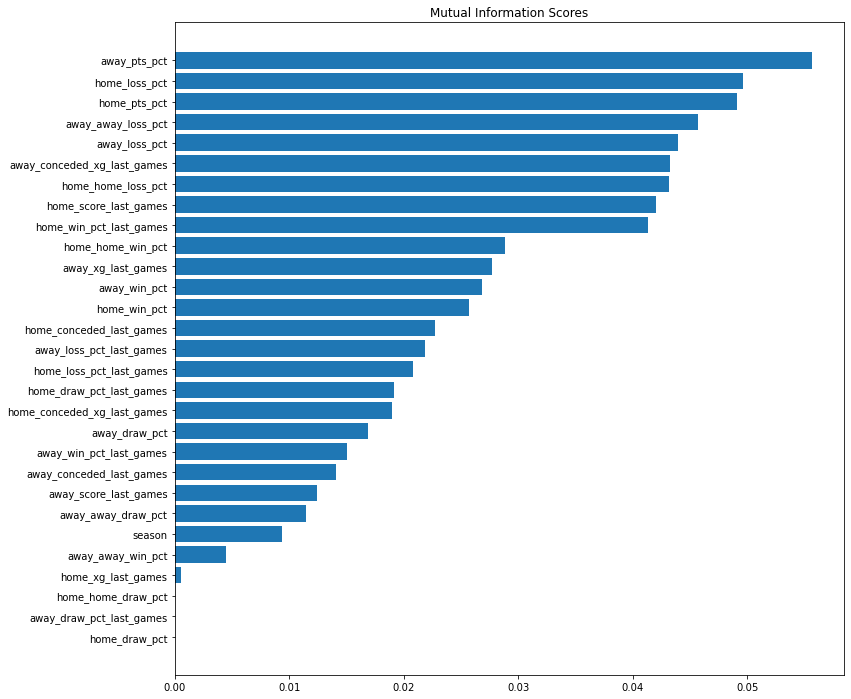

In [84]:
X_train = hf.transform_x(X_train, categorical_cols, numerical_cols)
X_test = hf.transform_x(X_test, categorical_cols, numerical_cols)

display(X_train)
first_mi_scores = hf.make_mi_scores(X_train, y_train)
hf.plot_mi_scores(first_mi_scores)

In [85]:
hf.create_cluster_features(X_train, X_test, first_mi_scores)

Total features to consider when clustering: 29


,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29
0,2017.0,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,40.000000,40.0,0.0,...,0,2,2,0,0,3,3,2,3,2
1,2017.0,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,33.333333,20.0,40.0,...,0,0,2,0,4,1,3,0,2,3
2,2017.0,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,80.000000,20.0,0.0,...,0,0,0,0,0,3,3,2,4,2
3,2017.0,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,20.000000,20.0,20.0,...,1,2,4,0,0,3,3,0,2,1
4,2017.0,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,20.000000,20.0,40.0,...,3,0,0,0,0,3,1,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2021.0,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,66.666667,0.0,20.0,...,4,4,4,1,2,1,3,2,3,0
1390,2021.0,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,11.111111,80.0,20.0,...,0,3,3,1,2,4,4,2,4,0
1391,2021.0,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,0.000000,80.0,20.0,...,1,1,0,1,2,4,3,2,3,2
1392,2021.0,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,38.888889,40.0,20.0,...,4,3,0,1,2,0,0,3,2,3


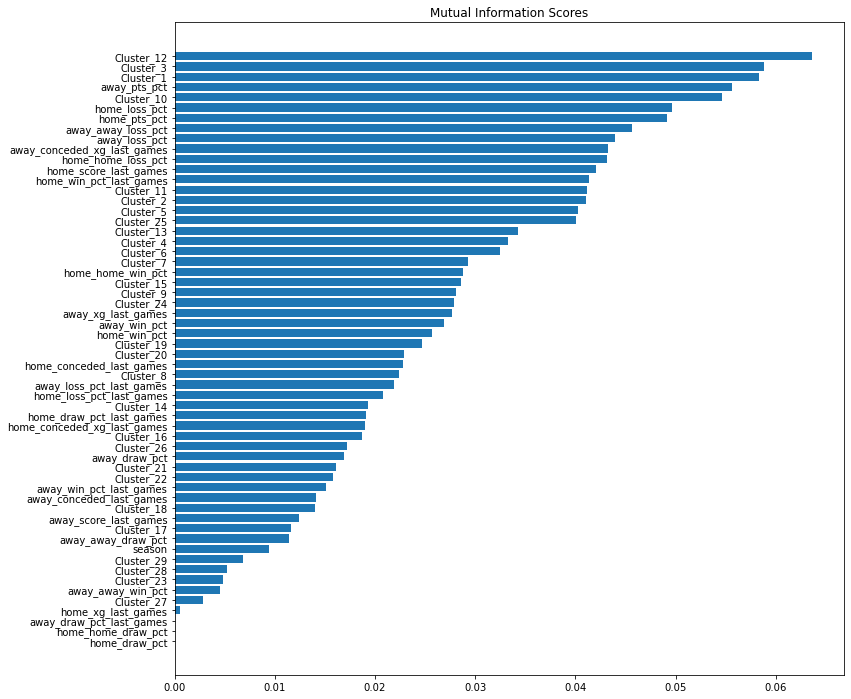

In [86]:
display(X_train)
second_mi_scores = hf.make_mi_scores(X_train, y_train)
hf.plot_mi_scores(second_mi_scores)

In [87]:
X_train, X_test = hf.apply_pca_datasets(X_train, X_test, second_mi_scores)

Total features to consider when doing the PCA: 54


In [88]:
if run_random_search: hf.run_random_forest_random_search(X_train, y_train)
    
# Best models found by the RandomSearch algorithm
# GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, random_state=0)
# RandomForestClassifier(criterion='entropy', max_depth=50, max_features='log2',
#                        min_samples_leaf=2, min_samples_split=10,
#                        n_estimators=2000, random_state=0)

,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54
0,2017.0,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,40.000000,40.0,0.0,...,0.041941,0.039997,0.033460,0.011445,-0.029195,4.288479e-15,2.820522e-16,2.153227e-16,6.426486e-16,-1.661024e-16
1,2017.0,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,33.333333,20.0,40.0,...,-0.096889,-0.119189,0.037254,0.011399,-0.071709,-8.428944e-16,1.035465e-15,1.064892e-15,-5.307218e-16,3.325709e-17
2,2017.0,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,80.000000,20.0,0.0,...,-0.068181,-0.126532,-0.050085,-0.036916,-0.068236,-9.584591e-16,3.827669e-17,7.382313e-17,-1.592548e-16,-1.138644e-16
3,2017.0,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,20.000000,20.0,20.0,...,-0.140823,0.004974,0.049454,0.008060,0.002684,-7.383953e-16,-2.486001e-16,-9.549913e-17,1.608694e-16,-1.689692e-16
4,2017.0,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,20.000000,20.0,40.0,...,0.067381,0.096181,0.043610,0.020720,0.014269,-1.527091e-16,-2.587596e-16,1.192612e-16,3.732925e-16,9.652959e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2021.0,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,66.666667,0.0,20.0,...,0.133847,0.089229,-0.089598,-0.040365,0.011710,-2.187623e-16,5.378841e-17,1.499376e-17,-3.802817e-17,1.545271e-17
1390,2021.0,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,11.111111,80.0,20.0,...,0.004352,-0.086464,-0.021714,0.008775,-0.017675,3.691081e-17,1.828445e-17,1.075465e-17,5.475688e-17,-1.287813e-17
1391,2021.0,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,0.000000,80.0,20.0,...,0.075077,0.171954,0.001389,0.031297,-0.011477,6.259379e-17,-2.363236e-17,-4.376465e-17,1.569613e-18,-1.047882e-17
1392,2021.0,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,38.888889,40.0,20.0,...,-0.096925,0.020244,-0.043974,0.049827,-0.062626,-6.930634e-17,-5.284843e-17,5.711199e-18,2.160378e-17,4.930959e-18


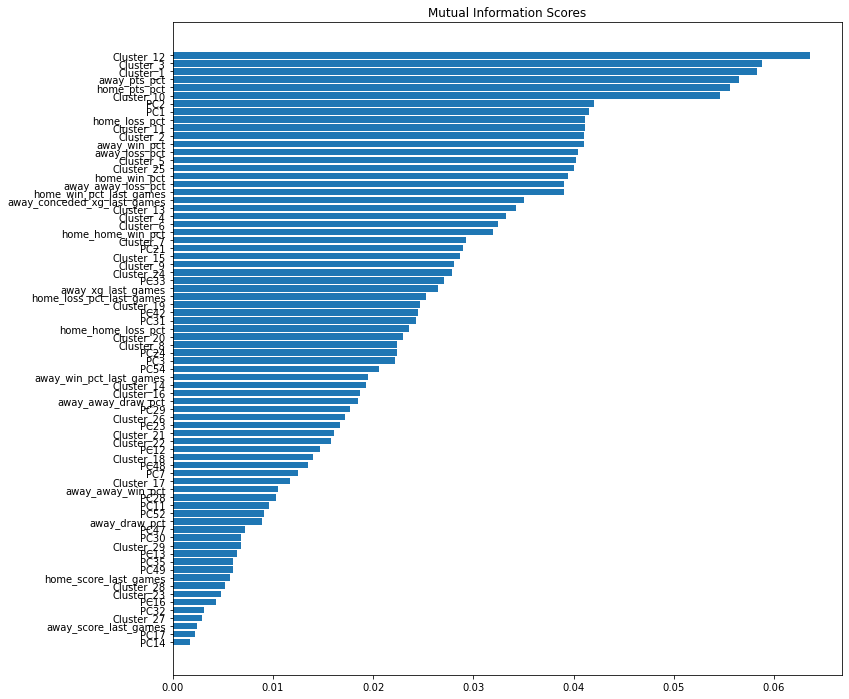

In [89]:
display(X_train)
min_mi_score=0.001
third_mi_scores = hf.make_mi_scores(X_train, y_train)
hf.plot_mi_scores(third_mi_scores[third_mi_scores > min_mi_score])

In [90]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='sqrt',
                         min_samples_leaf=1, min_samples_split=50,
                         n_estimators=2000, random_state=0)
my_pipeline = hf.build_pipeline(X_train, y_train, model)

In [91]:
test_results_df = hf.build_pred_df(my_pipeline, X_test, y_test, odds_test)

Classification Report:
              precision    recall  f1-score   support

           A       0.51      0.44      0.48        86
           D       0.00      0.00      0.00        52
           H       0.57      0.86      0.68       123

    accuracy                           0.55       261
   macro avg       0.36      0.43      0.39       261
weighted avg       0.44      0.55      0.48       261

Confusion Matrix:
[[106   0  17]
 [ 33   0  19]
 [ 48   0  38]]


Times when H was predicted: 187 (0.72)
Times when D was predicted: 0 (0.0)
Times when A was predicted: 74 (0.28)

Model profit: 4407.663054319448
Maximum negative sequence:  6
Maximum positive sequence:  8


In [92]:
display(test_results_df)

,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,profit,progress
1394,A,H,0.200386,0.268208,0.531405,2.66,2.79,3.21,-355.241599,2000.000000
1395,H,H,0.199424,0.254112,0.546463,1.67,5.31,3.90,184.172763,1828.931164
1396,H,H,0.283845,0.304319,0.411836,2.95,2.43,3.39,414.292656,2243.223820
1397,H,H,0.123343,0.173835,0.702822,1.23,13.00,6.68,106.079193,2349.303013
1398,H,H,0.335262,0.266466,0.398271,2.06,3.65,3.49,112.540275,2461.843288
...,...,...,...,...,...,...,...,...,...,...
1650,D,H,0.322850,0.296918,0.380233,3.14,2.31,3.44,-182.854623,5803.638397
1651,H,A,0.524355,0.226396,0.249249,5.18,1.64,4.16,-234.328002,5569.310395
1652,H,H,0.298257,0.260645,0.441098,2.61,2.68,3.46,365.405341,5934.715736
1653,H,H,0.178467,0.202207,0.619325,1.21,12.68,7.30,63.990798,5998.706534


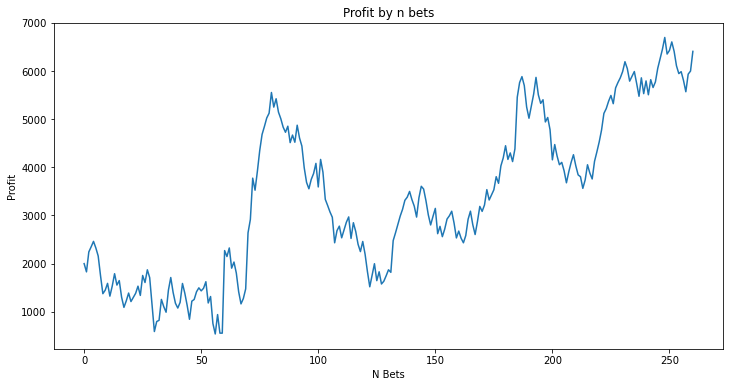

In [93]:
hf.plot_betting_progress(test_results_df)